In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import nltk

import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from PIL import Image
plane_mask = np.array(Image.open('../docs/img/airplane.jpg'))
sns.set()

In [2]:
df = pd.read_csv('../data/cleaned_tweets.csv')
# some tweets only contained stop words or mentions so are null
# --> change to empty string
df['cleaned_tweet'] = np.where(df.cleaned_tweet.isnull(), '', df.cleaned_tweet)

In [4]:
df.airline.unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [5]:
df.airline_sentiment.value_counts()

negative    9080
neutral     3057
positive    2290
Name: airline_sentiment, dtype: int64

In [6]:
df.groupby('airline').airline_sentiment.value_counts()

airline         airline_sentiment
American        negative             1864
                neutral               431
                positive              299
Delta           negative              955
                neutral               723
                positive              533
Southwest       negative             1185
                neutral               658
                positive              565
US Airways      negative             2262
                neutral               380
                positive              264
United          negative             2633
                neutral               694
                positive              478
Virgin America  negative              181
                neutral               171
                positive              151
Name: airline_sentiment, dtype: int64

In [7]:
cmap = sns.color_palette('colorblind')

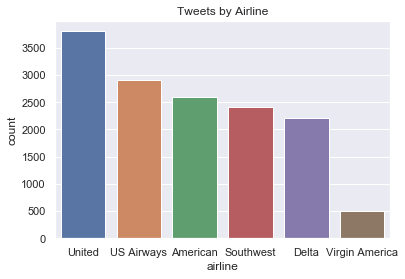

In [65]:
sns.countplot(x='airline', data=df, order=df['airline'].value_counts().index)
plt.title('Tweets by Airline')
plt.savefig('../docs/img/tweets_by_airline.png', dpi=300, bbox_inches='tight');

In [9]:
# total counts of tweets by airline
airline_counts = df.groupby('airline')[['tweet_id']].count().reset_index()
airline_counts.rename({'tweet_id': 'total_tweets'}, axis=1, inplace=True)

In [10]:
# total counts of tweets by airline and sentiment
sentiment_counts_by_airline = (
    df.groupby(['airline', 'airline_sentiment'])
    [['tweet_id']].count()
    .reset_index()
    .sort_values(by='airline')
)

In [11]:
sentiment_counts_by_airline = sentiment_counts_by_airline.merge(airline_counts)
# get percentage of each sentiment
sentiment_counts_by_airline['perc'] = (
    sentiment_counts_by_airline.tweet_id / sentiment_counts_by_airline.total_tweets
)
sentiment_counts_by_airline

,airline,airline_sentiment,tweet_id,total_tweets,perc
0,American,negative,1864,2594,0.718581
1,American,neutral,431,2594,0.166153
2,American,positive,299,2594,0.115266
3,Delta,negative,955,2211,0.431931
4,Delta,neutral,723,2211,0.327001
5,Delta,positive,533,2211,0.241067
6,Southwest,neutral,658,2408,0.273256
7,Southwest,positive,565,2408,0.234635
8,Southwest,negative,1185,2408,0.492110
9,US Airways,negative,2262,2906,0.778390


In [73]:
negative

,airline,perc
5,Virgin America,0.359841
1,Delta,0.431931
2,Southwest,0.492110
4,United,0.691984
0,American,0.718581
3,US Airways,0.778390


In [79]:
negative

,airline,perc
3,US Airways,0.778390
0,American,0.718581
4,United,0.691984
2,Southwest,0.492110
1,Delta,0.431931
5,Virgin America,0.359841


In [83]:
(sentiment_counts_by_airline[
    sentiment_counts_by_airline.airline_sentiment == 'neutral'
][['airline', 'perc']])
          #.reset_index(drop=True))

,airline,perc
1,American,0.166153
4,Delta,0.327001
6,Southwest,0.273256
10,US Airways,0.130764
13,United,0.182392
15,Virgin America,0.339960


In [86]:
negative

,airline,perc
3,US Airways,0.778390
0,American,0.718581
4,United,0.691984
2,Southwest,0.492110
1,Delta,0.431931
5,Virgin America,0.359841


In [87]:
positive

,perc
0,0.090847
1,0.115266
2,0.125624
3,0.234635
4,0.241067
5,0.300199


In [90]:
negative

,airline,perc
3,US Airways,0.778390
0,American,0.718581
4,United,0.691984
2,Southwest,0.492110
1,Delta,0.431931
5,Virgin America,0.359841


In [91]:
positive

,perc
airline,
US Airways,0.090847
American,0.115266
United,0.125624
Southwest,0.234635
Delta,0.241067
Virgin America,0.300199


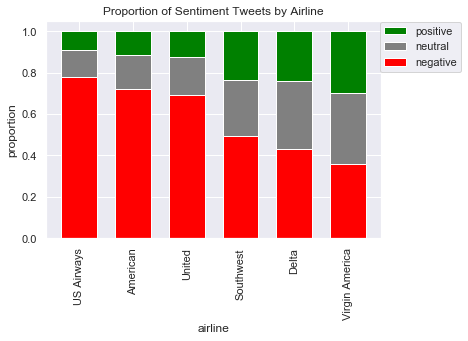

In [99]:
negative = (sentiment_counts_by_airline[
    sentiment_counts_by_airline.airline_sentiment == 'negative'
][['airline', 'perc']]
           .set_index('airline')
           .sort_values(by='perc', ascending=False))
neutral = (sentiment_counts_by_airline[
    sentiment_counts_by_airline.airline_sentiment == 'neutral'
][['airline', 'perc']]
          .reset_index(drop=True)
          .set_index('airline')
          .loc[negative.index.tolist()])
positive = (sentiment_counts_by_airline[
    sentiment_counts_by_airline.airline_sentiment == 'positive'
][['airline', 'perc']]
           .reset_index(drop=True)
           .set_index('airline')
           .loc[negative.index.tolist()])

ind = np.arange(0.5, 6.7, 1.2)
p1 = plt.bar(ind, negative.perc,  color='red')
p2 = plt.bar(ind, neutral.perc, 
             bottom=negative.perc, color='grey')
p3 = plt.bar(ind, positive.perc,
             bottom=negative.perc+neutral.perc, color='green')

plt.xlabel('airline')
plt.ylabel('proportion')
plt.title('Proportion of Sentiment Tweets by Airline')
plt.xticks(ind, negative.index, rotation=90)
plt.legend((p3[0], p2[0], p1[0]), ('positive', 'neutral', 'negative'), bbox_to_anchor=(.98,1.02))
plt.savefig('../docs/img/sentiment_perc_by_airline.png', dpi=300, bbox_inches='tight');

In [13]:
# counts of negative tweets
neg_counts = (df[df.airline_sentiment == 'negative']
              .groupby('airline')[['tweet_id']]
              .count()
              .reset_index())
neg_counts.rename({'tweet_id': 'total_tweets'}, axis=1, inplace=True)

In [14]:
# counts of negative reason by airline
neg_reasons = (df[df.airline_sentiment == 'negative']
     .groupby(['airline', 'negativereason'])
     .tweet_id.count()
     .reset_index()
     .sort_values(by=['airline', 'tweet_id'], ascending=False)
     .merge(neg_counts)) 
# remove the rows where the negative reason could not be determined
neg_reasons = neg_reasons[neg_reasons.negativereason != "Can't Tell"].copy()
# percentages of negative reasons by airline
neg_reasons['perc'] = neg_reasons.tweet_id / neg_reasons.total_tweets
# get top 3 negative reasons
neg_reasons = neg_reasons.groupby(['airline']).head(3).sort_values(by='airline')

In [109]:
cs_issue

,perc
airline,
American,0.398605
US Airways,0.358090
Virgin America,0.331492
Southwest,0.329114
United,0.258640
Delta,0.208377


In [108]:
late

,perc
airline,
American,0.125536
US Airways,0.200265
Virgin America,0.000000
Southwest,0.128270
United,0.199392
Delta,0.281675


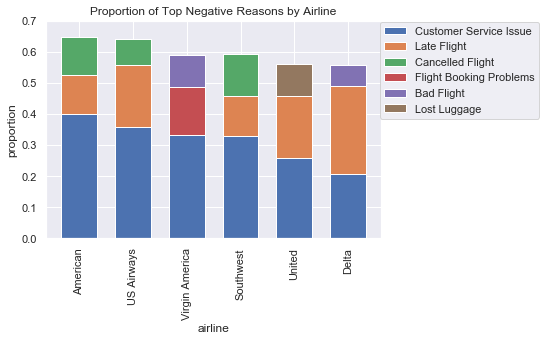

In [118]:
# creating a df with just airline names to merge when an airline does not
# have a particular negative reason in their top 3 (to fill with 0)
airlines = pd.DataFrame(neg_reasons.airline.unique(), columns=['airline'])

cs_issue = (neg_reasons[neg_reasons.negativereason == 'Customer Service Issue']
            [['airline', 'perc']]
            .sort_values(by='perc', ascending=False)
            .set_index('airline'))
late = (neg_reasons[neg_reasons.negativereason == 'Late Flight']
        .merge(airlines, how='right')
        .fillna(0)
        [['airline', 'perc']]
        .set_index('airline')
        .loc[cs_issue.index])
cancelled = (neg_reasons[neg_reasons.negativereason == 'Cancelled Flight']
             .merge(airlines, how='right')
             .fillna(0)
             [['airline', 'perc']]
             .set_index('airline')
             .loc[cs_issue.index])
booking = (neg_reasons[neg_reasons.negativereason == 'Flight Booking Problems']
           .merge(airlines, how='right')
           .fillna(0)
           [['airline', 'perc']]
           .set_index('airline')
           .loc[cs_issue.index])
bad = (neg_reasons[neg_reasons.negativereason == 'Bad Flight']
       .merge(airlines, how='right')
       .fillna(0)
       [['airline', 'perc']]
       .set_index('airline')
       .loc[cs_issue.index])
lost = (neg_reasons[neg_reasons.negativereason == 'Lost Luggage']
       .merge(airlines, how='right')
       .fillna(0)
       [['airline', 'perc']]
       .set_index('airline')
       .loc[cs_issue.index])

p1 = plt.bar(ind, cs_issue.perc)
p2 = plt.bar(ind, late.perc, bottom=cs_issue.perc)
p3 = plt.bar(ind, cancelled.perc, bottom=cs_issue.perc+late.perc)
p4 = plt.bar(ind, booking.perc,
             bottom=cs_issue.perc+late.perc+cancelled.perc)
p5 = plt.bar(ind, bad.perc,
             bottom=cs_issue.perc+late.perc+cancelled.perc+booking.perc)
p6 = plt.bar(ind, lost.perc,
             bottom=cs_issue.perc+late.perc+cancelled.perc+booking.perc+bad.perc)

plt.xlabel('airline')
plt.ylabel('proportion')
plt.title('Proportion of Top Negative Reasons by Airline')
plt.xticks(ind, cs_issue.index, rotation=90)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), 
           ('Customer Service Issue', 'Late Flight', 'Cancelled Flight', 
            'Flight Booking Problems', 'Bad Flight', 'Lost Luggage'),
           bbox_to_anchor=(.98,1.02))
plt.ylim(0, .7)
plt.savefig('../docs/img/negreasons.png', dpi=300, bbox_inches='tight');

In [16]:
pos_tweets = df[df.airline_sentiment == 'positive'].cleaned_tweet

pos_tokens = []
for tweet in pos_tweets:
    if tweet is np.nan:
        continue
    pos_tokens.extend(tweet.split())

In [17]:
neg_tweets = df[df.airline_sentiment == 'negative'].cleaned_tweet

neg_tokens = []
for tweet in neg_tweets:
    if tweet is np.nan:
        continue
    neg_tokens.extend(tweet.split())

In [18]:
nltk.FreqDist(pos_tokens).most_common(10)

[('thank', 1016),
 ('flight', 440),
 ('great', 231),
 ('just', 176),
 ('love', 161),
 ('servic', 160),
 ('help', 153),
 ('fli', 131),
 ('custom', 122),
 ('guy', 121)]

In [19]:
nltk.FreqDist(neg_tokens).most_common(10)

[('flight', 3524),
 ('hour', 1086),
 ('cancel', 901),
 ('delay', 884),
 ('custom', 768),
 ('servic', 762),
 ('time', 738),
 ('help', 714),
 ('wait', 655),
 ('bag', 648)]

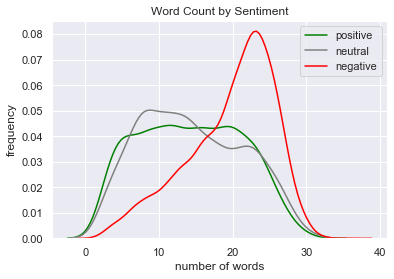

In [20]:
sns.distplot(df[df.airline_sentiment == 'positive'].n_words, hist=False,
             label='positive', color='green')
sns.distplot(df[df.airline_sentiment == 'neutral'].n_words, hist=False, 
             label='neutral', color='grey')
sns.distplot(df[df.airline_sentiment == 'negative'].n_words, hist=False,
             label='negative', color='red')
plt.xlabel('number of words')
plt.ylabel('frequency')
plt.title('Word Count by Sentiment')
plt.savefig('../docs/img/n_words.png', dpi=300, bbox_inches='tight');

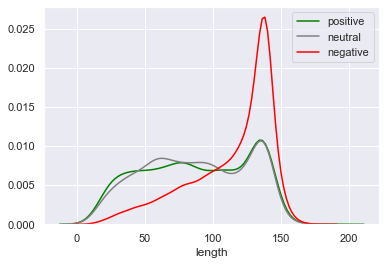

In [21]:
sns.distplot(df[df.airline_sentiment == 'positive'].length, hist=False,
             label='positive', color='green')
sns.distplot(df[df.airline_sentiment == 'neutral'].length, hist=False,
             label='neutral', color='grey')
sns.distplot(df[df.airline_sentiment == 'negative'].length, hist=False,
             label='negative', color='red');

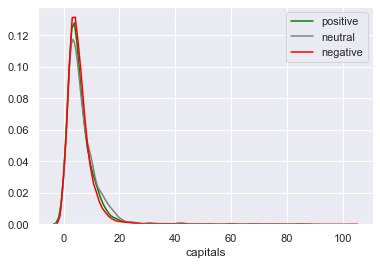

In [22]:
sns.distplot(df[df.airline_sentiment == 'positive'].capitals, hist=False,
             label='positive', color='green')
sns.distplot(df[df.airline_sentiment == 'neutral'].capitals, hist=False, 
             label='neutral', color='grey')
sns.distplot(df[df.airline_sentiment == 'negative'].capitals, hist=False,
             label='negative', color='red');

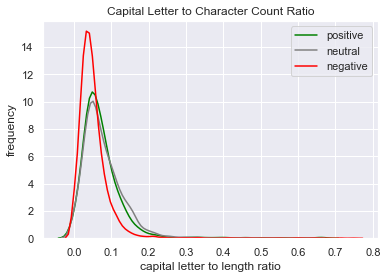

In [23]:
sns.distplot(df[df.airline_sentiment == 'positive'].cap_length_ratio, hist=False,
             label='positive', color='green', norm_hist=True)
sns.distplot(df[df.airline_sentiment == 'neutral'].cap_length_ratio, hist=False,
             label='neutral', color='grey', norm_hist=True)
sns.distplot(df[df.airline_sentiment == 'negative'].cap_length_ratio, hist=False,
             label='negative', color='red', norm_hist=True)
plt.xlabel('capital letter to length ratio')
plt.ylabel('frequency')
plt.title('Capital Letter to Character Count Ratio')
plt.savefig('../docs/img/caplength_dists.png', dpi=300, bbox_inches='tight');

In [24]:
# finding number/percentage of tweets that have happy emoticons
df['has_happy'] = np.where(df.n_happy > 0, 1, 0)
happy_props = np.divide(df.groupby('airline_sentiment')[['has_happy']].sum(),
                        df.groupby('airline_sentiment')[['has_happy']].count()) * 100
happy_props

,has_happy
airline_sentiment,
negative,0.264317
neutral,1.602879
positive,7.117904


In [25]:
# finding number/percentage of tweets that have sad emoticons
df['has_sad'] = np.where(df.n_sad > 0, 1, 0)
sad_props = np.divide(df.groupby('airline_sentiment')[['has_sad']].sum(),
                      df.groupby('airline_sentiment')[['has_sad']].count()) * 100
sad_props

,has_sad
airline_sentiment,
negative,0.881057
neutral,0.425254
positive,0.218341


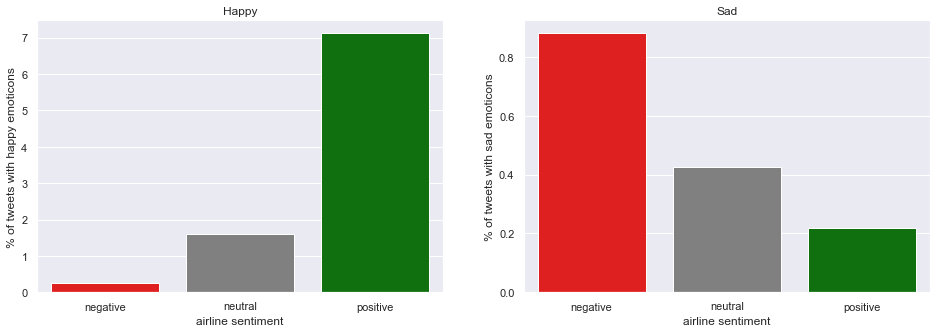

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(x='airline_sentiment', y='has_happy', data=happy_props.reset_index(),
           palette=sns.color_palette(['red', 'grey', 'green']), ax=axs[0])
axs[0].set_ylabel('% of tweets with happy emoticons')
axs[0].set_xlabel('airline sentiment')
axs[0].set_title('Happy')
sns.barplot(x='airline_sentiment', y='has_sad', data=sad_props.reset_index(),
           palette=sns.color_palette(['red', 'grey', 'green']), ax=axs[1])
axs[1].set_ylabel('% of tweets with sad emoticons')
axs[1].set_xlabel('airline sentiment')
axs[1].set_title('Sad')
plt.savefig('../docs/img/sad_happy_props.png', dpi=300, bbox_inches='tight');

In [27]:
# finding number/percentage of tweets that have exclamations
df['has_exclamation'] = np.where(df.n_exclamations > 0, 1, 0)
exclam_props = np.divide(df.groupby('airline_sentiment')[['has_exclamation']].sum(),
                         df.groupby('airline_sentiment')[['has_exclamation']].count()) * 100
exclam_props

,has_exclamation
airline_sentiment,
negative,17.048458
neutral,14.622179
positive,50.917031


In [28]:
# finding number/percentage of tweets that have question marks
df['has_question'] = np.where(df.n_questions > 0, 1, 0)
quest_props = np.divide(df.groupby('airline_sentiment')[['has_question']].sum(),
                        df.groupby('airline_sentiment')[['has_question']].count()) * 100
quest_props

,has_question
airline_sentiment,
negative,25.925110
neutral,38.730782
positive,4.497817


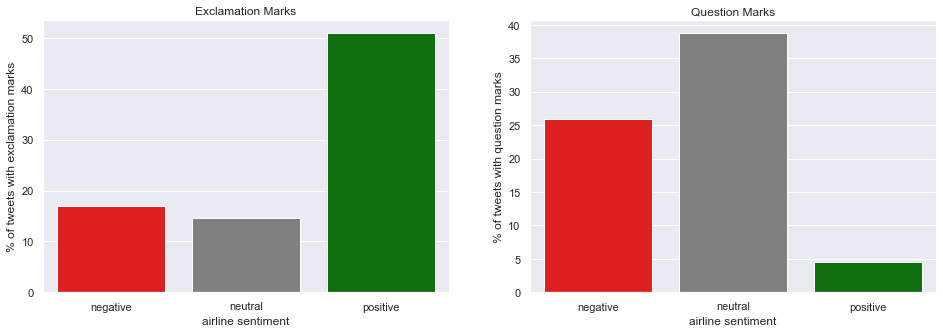

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(x='airline_sentiment', y='has_exclamation', data=exclam_props.reset_index(),
           palette=sns.color_palette(['red', 'grey', 'green']), ax=axs[0])
axs[0].set_ylabel('% of tweets with exclamation marks')
axs[0].set_xlabel('airline sentiment')
axs[0].set_title('Exclamation Marks')
sns.barplot(x='airline_sentiment', y='has_question', data=quest_props.reset_index(),
           palette=sns.color_palette(['red', 'grey', 'green']), ax=axs[1])
axs[1].set_ylabel('% of tweets with question marks')
axs[1].set_xlabel('airline sentiment')
axs[1].set_title('Question Marks')
plt.savefig('../docs/img/marks_props.png', dpi=300, bbox_inches='tight');

In [30]:
all_arrays = {}
features = ['n_words', 'cap_length_ratio', 
            'n_happy', 'n_sad', 
            'n_exclamations', 'n_questions']

# create arrays for each feature
for feature in features:
    subset = df[['airline_sentiment', feature]]
    tuples = [tuple(x) for x in subset.values]
    data = np.rec.array(tuples,
                       dtype=[('airline_sentiment','<U13'),(feature, '<f8')])
    all_arrays[feature] = data

In [31]:
# dict for ANOVA f value and p value for each feature
anova_dict = {}
for feature in features:
    data = all_arrays[feature]
    f, p = ss.f_oneway(data[data['airline_sentiment'] == 'positive'][feature],
                     data[data['airline_sentiment'] == 'negative'][feature],
                     data[data['airline_sentiment'] == 'neutral'][feature])
    anova_dict[feature] = (f, p)

In [32]:
# n_words
f = anova_dict['n_words'][0]
p = anova_dict['n_words'][1]

print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['n_words']
mc = MultiComparison(data['n_words'], data['airline_sentiment'])
result = mc.tukeyhsd() 

print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 1190.2993982780445
p value: 0.0 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
negative neutral  -5.2443  -5.5545 -4.9342  True 
negative positive -5.4222   -5.769 -5.0754  True 
neutral  positive -0.1778  -0.5877  0.232  False 
-------------------------------------------------
['negative' 'neutral' 'positive']


In [33]:
# cap_length_ratio
f = anova_dict['cap_length_ratio'][0]
p = anova_dict['cap_length_ratio'][1]

print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['cap_length_ratio']
mc = MultiComparison(data['cap_length_ratio'], data['airline_sentiment'])
result = mc.tukeyhsd() 

print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 375.23716859176994
p value: 1.362962238834934e-159 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
negative neutral   0.0256   0.0231 0.0282  True 
negative positive  0.0232   0.0203 0.026   True 
neutral  positive -0.0024  -0.0058 0.0009 False 
------------------------------------------------
['negative' 'neutral' 'positive']


In [34]:
# n_happy
f = anova_dict['n_happy'][0]
p = anova_dict['n_happy'][1]

print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['n_happy']
mc = MultiComparison(data['n_happy'], data['airline_sentiment'])
result = mc.tukeyhsd() 

print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 277.40642616554317
p value: 6.070115970213005e-119 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff lower  upper  reject
-----------------------------------------------
negative neutral   0.0134  0.0071 0.0197  True 
negative positive  0.0707  0.0637 0.0778  True 
neutral  positive  0.0573  0.049  0.0657  True 
-----------------------------------------------
['negative' 'neutral' 'positive']


In [35]:
# n_sad
f = anova_dict['n_sad'][0]
p = anova_dict['n_sad'][1]

print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['n_sad']
mc = MultiComparison(data['n_sad'], data['airline_sentiment'])
result = mc.tukeyhsd() 

print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 7.787252253704415
p value: 0.0004167387282997848 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
negative neutral  -0.0048   -0.009 -0.0006  True 
negative positive -0.0068  -0.0115 -0.0022  True 
neutral  positive -0.0021  -0.0076  0.0035 False 
-------------------------------------------------
['negative' 'neutral' 'positive']


In [36]:
# n_exclamations
f = anova_dict['n_exclamations'][0]
p = anova_dict['n_exclamations'][1]

print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['n_exclamations']
mc = MultiComparison(data['n_exclamations'], data['airline_sentiment'])
result = mc.tukeyhsd() 

print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 401.27470377972537
p value: 2.536166911563089e-170 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
negative neutral  -0.0695  -0.1135 -0.0255  True 
negative positive  0.5572   0.508   0.6064  True 
neutral  positive  0.6267   0.5685  0.6849  True 
-------------------------------------------------
['negative' 'neutral' 'positive']


In [37]:
# n_questions
f = anova_dict['n_questions'][0]
p = anova_dict['n_questions'][1]

print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['n_questions']
mc = MultiComparison(data['n_questions'], data['airline_sentiment'])
result = mc.tukeyhsd() 

print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 264.4931394876217
p value: 1.5427712596432622e-113 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
negative neutral   0.1057   0.0738  0.1376  True 
negative positive -0.2946  -0.3303 -0.2589  True 
neutral  positive -0.4003  -0.4425 -0.3581  True 
-------------------------------------------------
['negative' 'neutral' 'positive']


In [38]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

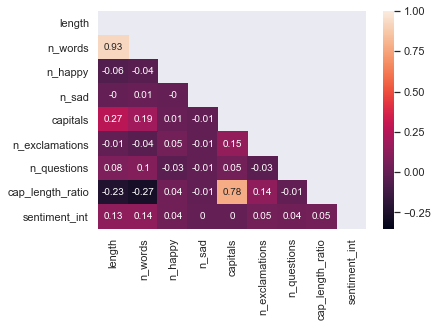

In [39]:
df['sentiment_int'] = df.airline_sentiment.map({
    'negative': -1,
    'neutral': 0,
    'positive': 1
})
corr = df[['length', 'n_words', 'n_happy', 'n_sad',
              'capitals', 'n_exclamations', 'n_questions', 'cap_length_ratio',
              'sentiment_int']].corr()

for col in corr.columns:
    if col != 'sentiment_int':
        # getting correlation ratio for sentiment and all continuous features
        corr.loc['sentiment_int', col] = correlation_ratio(df.sentiment_int,
                                                           df[col])
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(round(corr, 2), annot=True, mask=mask)
plt.savefig('../docs/img/correlations.png', dpi=300, bbox_inches='tight');

In [40]:
df['positive_sentiment'] = np.where(df.airline_sentiment == 'positive', 1, 0)
df['negative_sentiment'] = np.where(df.airline_sentiment == 'negative', 1, 0)

In [41]:
X = df.cleaned_tweet
y = df.positive_sentiment

# all unique tokens
all_tokens = set()
for tweet in X.tolist():
    all_tokens.update(tweet.split())
all_tokens = pd.Series(list(all_tokens))

In [42]:
pos_steps = [('tfidf', TfidfVectorizer()), ('logreg', LogisticRegression())]
pos_pipe = Pipeline(pos_steps)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [44]:
y_train.value_counts() / len(y_train)

0    0.841256
1    0.158744
Name: positive_sentiment, dtype: float64

In [45]:
y_test.value_counts() / len(y_test)

0    0.841303
1    0.158697
Name: positive_sentiment, dtype: float64

In [46]:
pos_pipe.fit(X_train, y_train)
pos_pipe.score(X_test, y_test)

0.9015939015939016

In [47]:
pos_df = (pd.DataFrame(zip(all_tokens, list(pos_pipe.predict_proba(all_tokens)[:,1])),
              columns=['token', 'prob'])
     .sort_values(by='prob', ascending=False)
     .reset_index(drop=True))
pos_df.head()

,token,prob
0,thank,0.995376
1,great,0.962404
2,love,0.945123
3,awesom,0.941375
4,best,0.915668


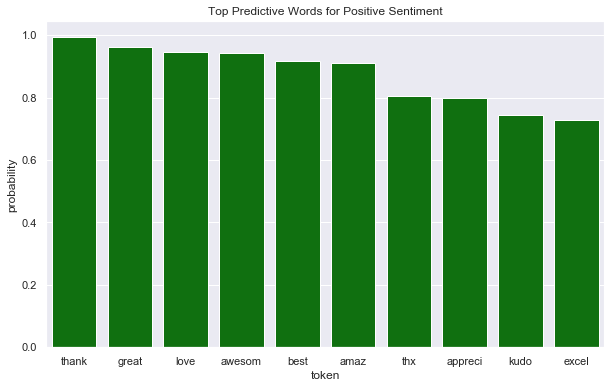

In [48]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='token', y='prob', data=pos_df.head(10), ax=ax, color='green')
ax.set_ylabel('probability')
ax.set_title('Top Predictive Words for Positive Sentiment')
plt.savefig('../docs/img/top_pred_pos.png', dpi=300, bbox_inches='tight');

In [49]:
X = df.cleaned_tweet
y = df.negative_sentiment

In [50]:
neg_steps = [('tfidf', TfidfVectorizer()), ('logreg', LogisticRegression())]
neg_pipe = Pipeline(pos_steps)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [52]:
neg_pipe.fit(X_train, y_train)
neg_pipe.score(X_test, y_test)

0.8133518133518134

In [53]:
neg_df = (pd.DataFrame(zip(all_tokens, list(neg_pipe.predict_proba(all_tokens)[:,1])),
              columns=['token', 'prob'])
     .sort_values(by='prob', ascending=False)
     .reset_index(drop=True))
neg_df.head()

,token,prob
0,hour,0.992742
1,worst,0.979640
2,delay,0.977618
3,hr,0.975975
4,cancel,0.961358


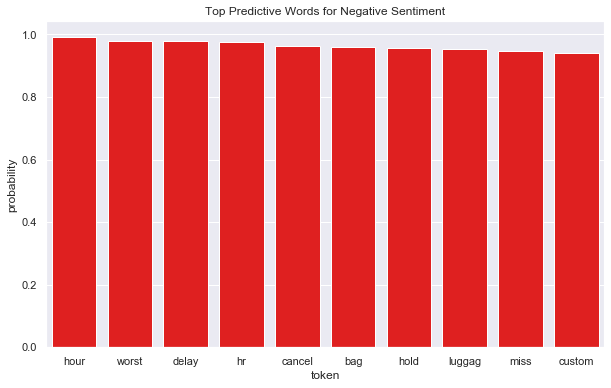

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='token', y='prob', data=neg_df.head(10), ax=ax, color='red')
ax.set_ylabel('probability')
ax.set_title('Top Predictive Words for Negative Sentiment')
plt.savefig('../docs/img/top_pred_neg.png', dpi=300, bbox_inches='tight');

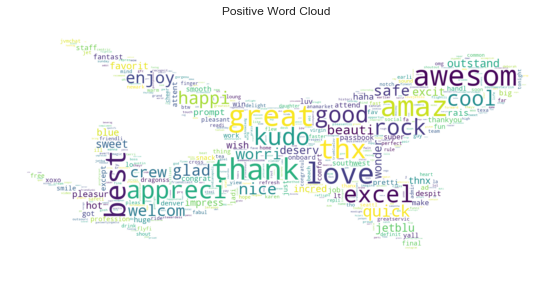

In [55]:
#all_words = ' '.join([text for text in df[df.airline_sentiment == 'positive']['cleaned_tweet']])
wordcloud = WordCloud(mask=plane_mask, background_color='white',
                      random_state=21, max_words=500, max_font_size=90).generate_from_frequencies(dict(pos_df.values))

plt.figure(figsize=(12, 5))
plt.imshow(wordcloud, interpolation="bilinear", aspect='equal')
plt.axis('off')
plt.title('Positive Word Cloud')
plt.savefig('../docs/img/pos_wordcloud.png', dpi=300, bbox_inches='tight');

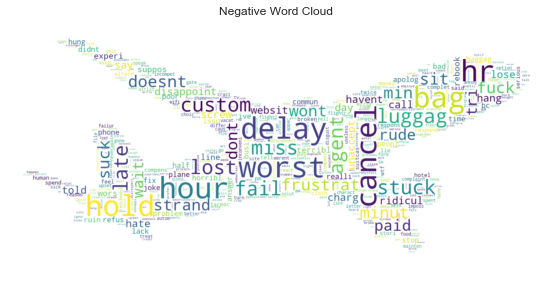

In [56]:
#all_words = ' '.join([text for text in df[df.airline_sentiment == 'negative']['cleaned_tweet']])
wordcloud = WordCloud(mask=plane_mask, background_color='white',
                     random_state=21, max_words=500, max_font_size=90).generate_from_frequencies(dict(neg_df.values))

plt.figure(figsize=(12, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Negative Word Cloud')
plt.savefig('../docs/img/negative_wordcloud.png', dpi=300, bbox_inches='tight');